In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256, 256),
    batch_size=32,
)

Found 2475 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']


In [5]:
len(dataset)

78

In [6]:
# 0,1,2,3...9 classes (10 classes)
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].shape)

(32, 256, 256, 3)
[1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1]
(256, 256, 3)


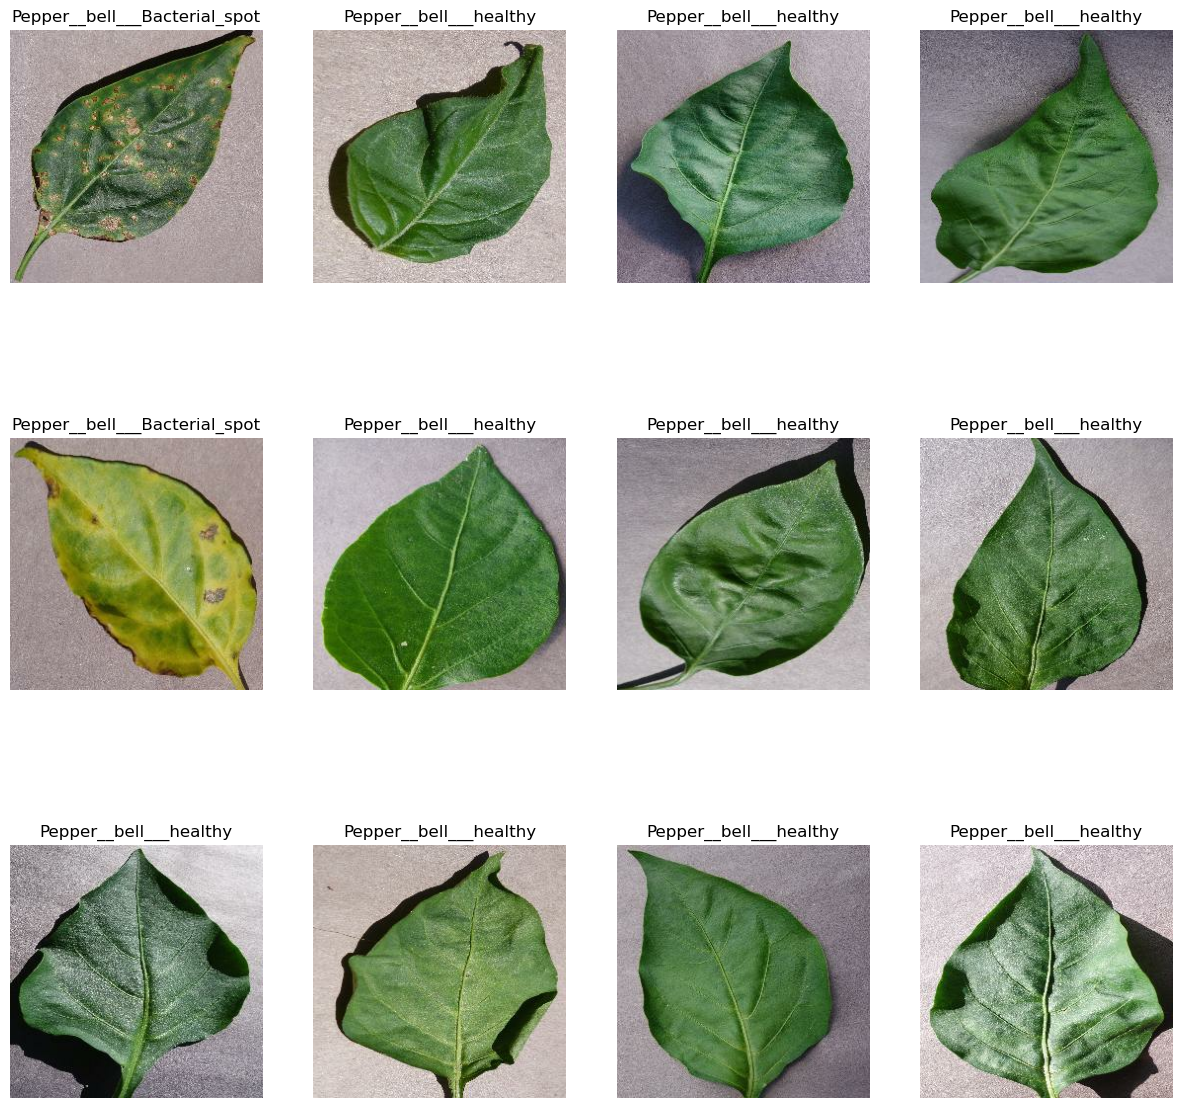

In [7]:
#visualize image
plt.figure(figsize=(15,15)) 
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
def dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

In [10]:
print(len(train_ds),
len(val_ds),
len(test_ds))

62 7 9


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
input_shape = (32, 256, 256, 3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [16]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [17]:
history = model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=50,
          batch_size=32,
          verbose=1)

Epoch 1/50


62/62 [==============================] - 14s 97ms/step - loss: 0.7773 - accuracy: 0.5909 - val_loss: 0.5788 - val_accuracy: 0.7232
Epoch 2/50
62/62 [==============================] - 5s 80ms/step - loss: 0.3918 - accuracy: 0.8268 - val_loss: 0.2194 - val_accuracy: 0.8929
Epoch 3/50
62/62 [==============================] - 5s 73ms/step - loss: 0.2471 - accuracy: 0.9266 - val_loss: 0.3115 - val_accuracy: 0.8661
Epoch 4/50
62/62 [==============================] - 5s 73ms/step - loss: 0.1810 - accuracy: 0.9542 - val_loss: 0.1195 - val_accuracy: 0.9375
Epoch 5/50
62/62 [==============================] - 5s 75ms/step - loss: 0.1287 - accuracy: 0.9638 - val_loss: 0.3986 - val_accuracy: 0.8571
Epoch 6/50
62/62 [==============================] - 5s 73ms/step - loss: 0.1152 - accuracy: 0.9745 - val_loss: 0.1584 - val_accuracy: 0.9330
Epoch 7/50
62/62 [==============================] - 5s 75ms/step - loss: 0.0584 - accuracy: 0.9837 - val_loss: 0.0613 - val_accuracy: 0.9821
Epoch 8/50
62/62 [=====

In [18]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 1s 18ms/step - loss: 0.0118 - accuracy: 0.9965


In [19]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 62}

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
history.history['accuracy']

[0.5909322500228882,
 0.8267956972122192,
 0.926642894744873,
 0.9541518092155457,
 0.9638308882713318,
 0.9745287895202637,
 0.9836984276771545,
 0.9913398027420044,
 0.9913398027420044,
 0.9938868880271912,
 0.9943963289260864,
 0.9857361316680908,
 0.9918491840362549,
 0.9928680658340454,
 0.9933775067329407,
 0.9943963289260864,
 0.9836984276771545,
 0.9867549538612366,
 0.9913398027420044,
 0.9979622960090637,
 0.998471736907959,
 0.9974528551101685,
 0.9959245920181274,
 0.998471736907959,
 0.9964340329170227,
 0.9938868880271912,
 0.9943963289260864,
 0.9949057698249817,
 0.996943473815918,
 0.9949057698249817,
 0.9949057698249817,
 0.9979622960090637,
 0.998471736907959,
 0.9994905591011047,
 0.9979622960090637,
 0.9989811778068542,
 0.9908303618431091,
 0.9938868880271912,
 0.9989811778068542,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9949057698249817,
 0.9821701645851135,
 0.9887926578521729,
 0.9954151511192322]

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

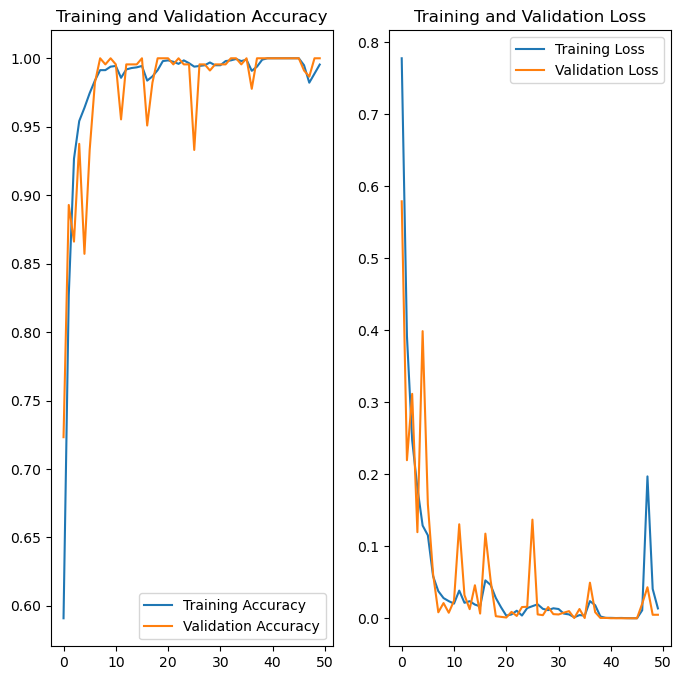

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual lable:  Pepper__bell___healthy
1/1 [==============================] - 0s 85ms/step
Predicted lable:  Pepper__bell___healthy


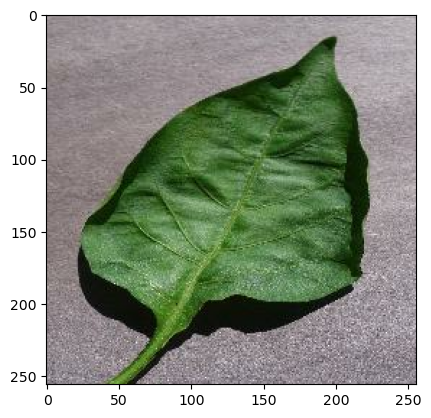

In [24]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype("uint8"))
    first_lable = label_batch[0].numpy()

    print("First image to predict")

    plt.imshow(first_image)
    print("Actual lable: ", class_names[first_lable])
    #print(class_names[first_lable])

    batch_prediction = model.predict(image_batch)
    print("Predicted lable: ", class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [26]:
plt.figure(figsize=(17,17))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]


        plt.title(f"Actual class: {actual_class}, \n Predicted class: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

1/1 [==============================] - 0s 12ms/step


In [27]:
model_version = "BellP_Training_v1"
model.save(f"../Models/{model_version}")



INFO:tensorflow:Assets written to: ../Models/BellP_Training_v1\assets


INFO:tensorflow:Assets written to: ../Models/BellP_Training_v1\assets
